In [35]:
# import modules
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from MLPTrainer import MLPTrainer
from XGBoost import XGBoostLoanModel
from LightGBM import LightGBMLoanModel
from LReg import LogisticRegressionLoanModel
from CatBoost import CatBoostLoanModel

In [11]:
# load data
df = pd.read_csv('../data/Loan_Default/Loan_Default.csv')
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
count,148670.000000,148670.0,145326,148670,147762,148670,148536,148670,148670,148670,...,148670,148670.000000,148670,148470,148470,133572.000000,148670,148670,148670.000000,124549.000000
unique,NaN,NaN,2,4,2,3,4,2,2,2,...,4,NaN,2,7,2,NaN,4,2,NaN,NaN
top,NaN,NaN,cf,Male,nopre,type1,p3,l1,nopc,nob/c,...,CIB,NaN,CIB,45-54,to_inst,NaN,North,direct,NaN,NaN
freq,NaN,NaN,135348,42346,124621,113173,55934,142344,148114,127908,...,48152,NaN,74392,34720,95814,NaN,74722,148637,NaN,NaN
mean,99224.500000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,699.789103,NaN,NaN,NaN,72.746457,NaN,NaN,0.246445,37.732932
std,42917.476598,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,115.875857,NaN,NaN,NaN,39.967603,NaN,NaN,0.430942,10.545435
min,24890.000000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,500.000000,NaN,NaN,NaN,0.967478,NaN,NaN,0.000000,5.000000
25%,62057.250000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,599.000000,NaN,NaN,NaN,60.474860,NaN,NaN,0.000000,31.000000
50%,99224.500000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,699.000000,NaN,NaN,NaN,75.135870,NaN,NaN,0.000000,39.000000
75%,136391.750000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,800.000000,NaN,NaN,NaN,86.184211,NaN,NaN,0.000000,45.000000


<Axes: >

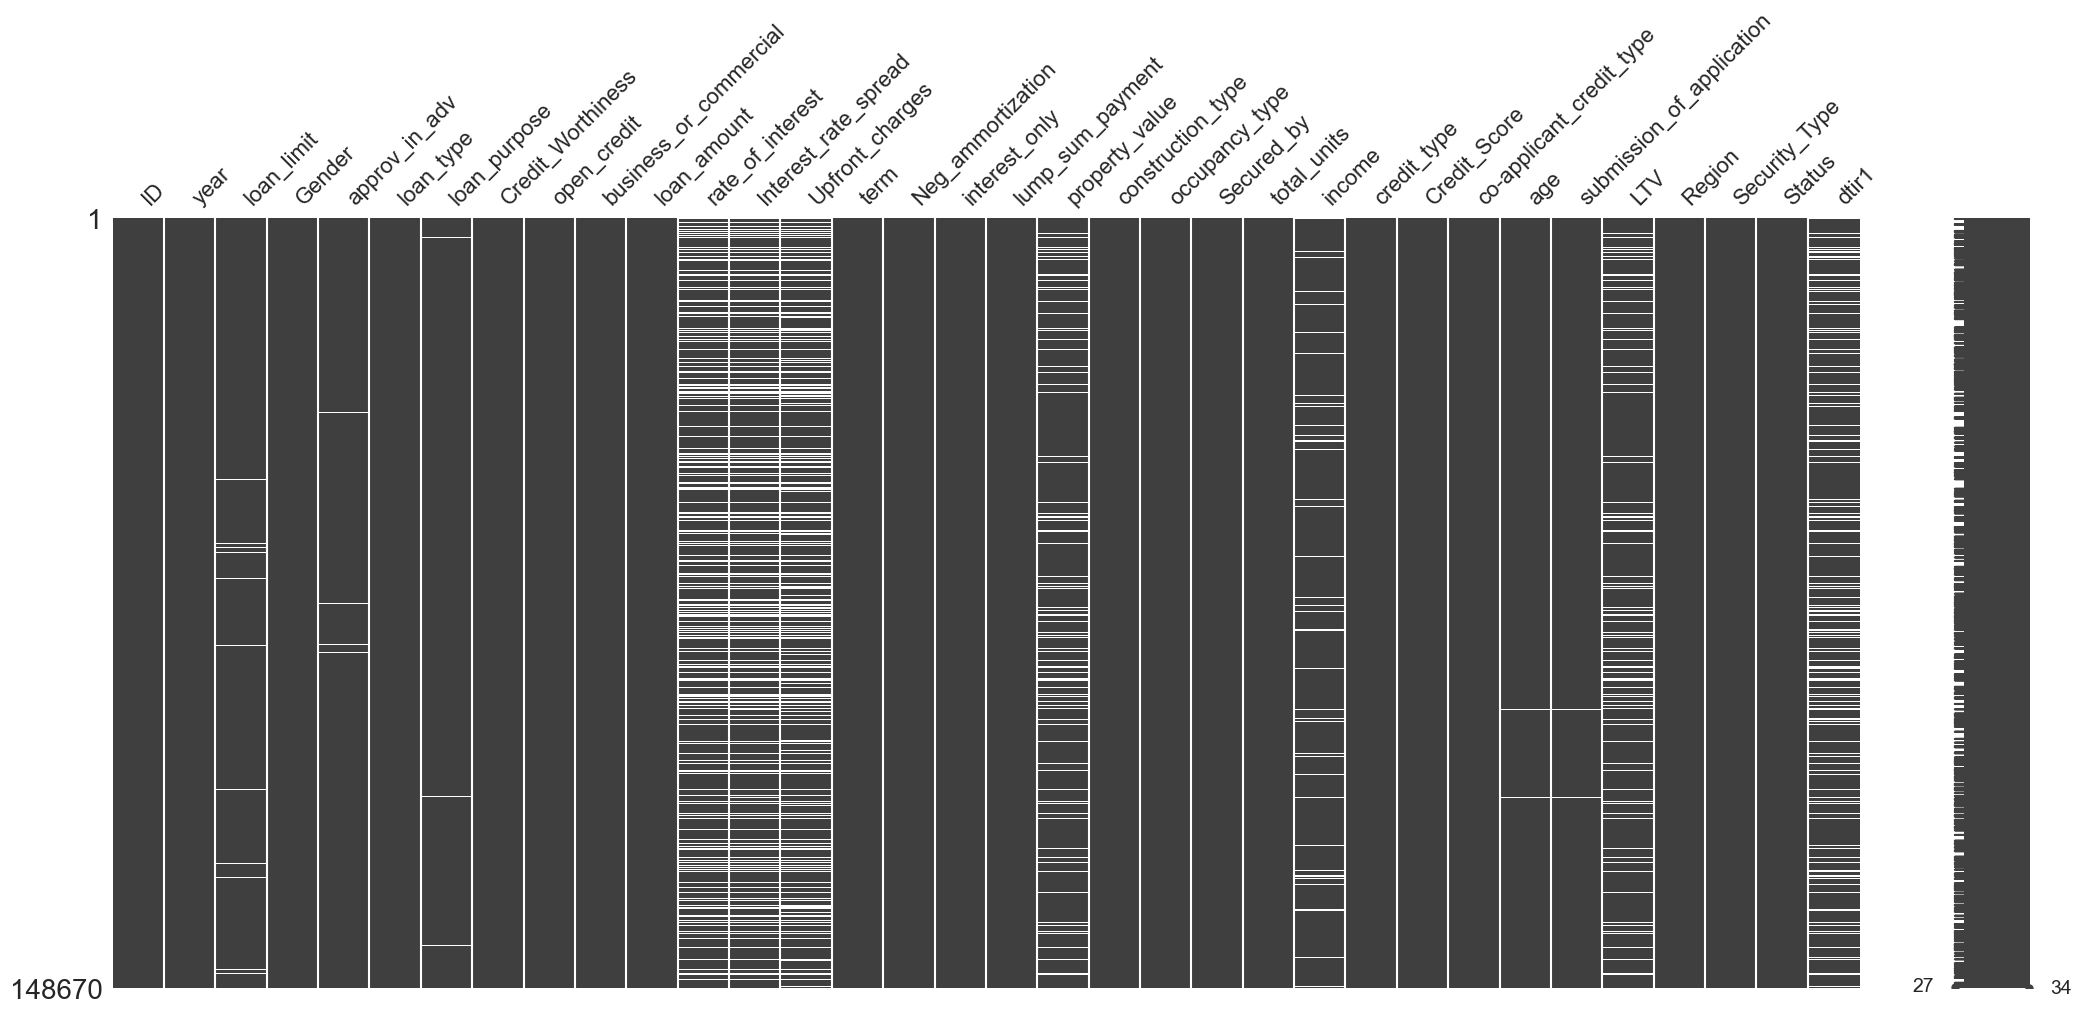

In [12]:
# pre-processing
# oberserve the missing data
df.isnull().sum()
# visualize the missing data
msno.matrix(df)

In [13]:
def classify_variables(df):
    # 初始化
    numerical_vars = []
    categorical_vars = []
    binary_vars = []
    ordinal_vars = []
    to_drop_vars = []
    target_var = 'Status'

    # 明确无用字段
    if 'ID' in df.columns:
        to_drop_vars.append('ID')

    for col in df.columns:
        if col == target_var or col in to_drop_vars:
            continue

        nunique = df[col].nunique()
        dtype = df[col].dtype

        # 1. 可能是布尔/二分类
        if nunique == 2:
            binary_vars.append(col)

        # 2. 数值型
        elif dtype in ['int64', 'float64']:
            numerical_vars.append(col)

        # 3. 明确是有顺序的分类变量
        elif col in ['Credit_Worthiness', 'total_units']:
            ordinal_vars.append(col)

        # 4. 其他默认是分类变量
        else:
            categorical_vars.append(col)

    return {
        "to_drop_vars": to_drop_vars,
        "target_var": target_var,
        "binary_vars": binary_vars,
        "ordinal_vars": ordinal_vars,
        "categorical_vars": categorical_vars,
        "numerical_vars": numerical_vars
    }

# 调用函数
var_classes = classify_variables(df)

# 输出结果
for k, v in var_classes.items():
    print(f"\n{k} ({len(v)}):\n{v}")


to_drop_vars (1):
['ID']

target_var (6):
Status

binary_vars (13):
['loan_limit', 'approv_in_adv', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'Secured_by', 'co-applicant_credit_type', 'submission_of_application', 'Security_Type']

ordinal_vars (1):
['total_units']

categorical_vars (7):
['Gender', 'loan_type', 'loan_purpose', 'occupancy_type', 'credit_type', 'age', 'Region']

numerical_vars (11):
['year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']


In [14]:
# drop useless columns
to_drop_vars= ['ID', 'year']

target_var = ['Status']

binary_vars  = ['loan_limit', 'approv_in_adv', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'Secured_by', 'co-applicant_credit_type', 'submission_of_application', 'Security_Type']

ordinal_vars = ['total_units']

categorical_vars = ['Gender', 'loan_type', 'loan_purpose', 'occupancy_type', 'credit_type', 'age', 'Region']

numerical_vars = ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

In [15]:
# drop useless columns
df = df.drop(columns=to_drop_vars)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              147762 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148536 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          14

In [16]:
# deal with missing data
# fill missing data
# numerical variables
for col in numerical_vars:
    df[col] = df[col].fillna(df[col].mean())
    
# categorical variables
for col in categorical_vars:
    df[col] = df[col].fillna(df[col].mode()[0])
    
# ordinal variables
for col in ordinal_vars:
    df[col] = df[col].fillna(df[col].mode()[0])
    
# binary variables
for col in binary_vars:
    df[col] = df[col].fillna(df[col].mode()[0])
    
df.isnull().sum()

loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security_Type                0
Status                       0
dtir1                        0
dtype: i

In [17]:
df = df.drop(columns=["Interest_rate_spread", "rate_of_interest", "Upfront_charges"])

上面这三列，所有的缺失值都对应着违约，同样，不缺失的对应不违约，经过查询得知，这是由于信息泄露，所以我们将这三列全部删除

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 148670 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              148670 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148670 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   term                       148670 non-null  float64
 10  Neg_ammortization          148670 non-null  object 
 11  interest_only              148670 non-null  object 
 12  lump_sum_payment           148670 non-null  object 
 13  property_value             14

In [19]:
# 选择数值列（排除非数值列）
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 计算 Z-Score
z_scores = np.abs(df[numeric_cols].apply(zscore))

# 设置阈值（通常 3 或 2.5）
threshold = 3
outliers = (z_scores > threshold)

outlier_rows = df[outliers.any(axis=1)]  # 只保留包含异常值的行

print(f"检测到 {len(outlier_rows)} 个异常值")

检测到 6821 个异常值


检测到很多异常值，但是好像并不是非常影响最后的训练结果，因此先不做处理

In [20]:
# ===== 1. 编码 ===== #

# 二分类变量编码（LabelEncoder）
le = LabelEncoder()
for col in binary_vars:
    df[col] = le.fit_transform(df[col])

# 有序变量编码（total_units: 1U, 2U, 3U, 4U）
unit_map = {'1U': 1, '2U': 2, '3U': 3, '4U': 4}
for col in ordinal_vars:
    df[col] = df[col].map(unit_map)

# One-Hot 编码分类变量
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# ===== 2. 标准化 ===== #

# scaler = StandardScaler()
# df[numerical_vars] = scaler.fit_transform(df[numerical_vars])

    
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 148670 non-null  int32  
 1   approv_in_adv              148670 non-null  int32  
 2   Credit_Worthiness          148670 non-null  int32  
 3   open_credit                148670 non-null  int32  
 4   business_or_commercial     148670 non-null  int32  
 5   loan_amount                148670 non-null  int64  
 6   term                       148670 non-null  float64
 7   Neg_ammortization          148670 non-null  int32  
 8   interest_only              148670 non-null  int32  
 9   lump_sum_payment           148670 non-null  int32  
 10  property_value             148670 non-null  float64
 11  construction_type          148670 non-null  int32  
 12  Secured_by                 148670 non-null  int32  
 13  total_units                14

,loan_limit,approv_in_adv,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,term,Neg_ammortization,interest_only,lump_sum_payment,...,credit_type_EXP,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,Region_North-East,Region_central,Region_south
0,0,0,0,0,1,116500,360.0,1,1,1,...,True,False,False,False,False,False,False,False,False,True
1,0,0,0,0,0,206500,360.0,1,1,0,...,False,False,False,True,False,False,False,False,False,False
2,0,1,0,0,1,406500,360.0,0,1,1,...,True,True,False,False,False,False,False,False,False,True
3,0,0,0,0,1,456500,360.0,1,1,1,...,True,False,True,False,False,False,False,False,False,False
4,0,1,0,0,1,696500,360.0,1,1,1,...,False,False,False,False,False,False,False,False,False,False


对**有序分类变量 `total_units`** 进行 **数值化编码**，目的是让机器学习模型能够理解这个变量的“顺序性”。

变量 `total_units` 表示房产包含的单位数量，比如：

- `1U` → 一户
- `2U` → 两户
- `3U` → 三户
- `4U` → 四户

这些是**有自然顺序的分类**（这就是“有序变量” / *ordinal variable* 的定义），例如：
- 明显地：4U > 3U > 2U > 1U
- 它们不是纯标签，而是有大小关系（越多户，可能贷款金额越高，风险也可能不同）
---
### 解释代码
```python
unit_map = {'1U': 1, '2U': 2, '3U': 3, '4U': 4}
for col in ordinal_vars:
    df[col] = df[col].map(unit_map)
```
#### `unit_map`
这是一个字典，表示将原来的字符串类别 **映射** 为整数。
#### `df[col] = df[col].map(unit_map)`
这一步将 DataFrame 中的 `total_units` 列，按 `unit_map` 映射成整数。例如原来是：
```python
['2U', '1U', '3U', '4U', '1U']
```
变成：
```python
[2, 1, 3, 4, 1]
```
### 为什么不能用 One-Hot？
如果你用 `get_dummies()`（One-Hot 编码）：
- 会拆成 `is_1U`, `is_2U`, `is_3U`, `is_4U` 四列
- 模型无法知道 4U 比 1U “大” → **顺序信息丢失**
而你现在用整数编码，是在**保留顺序结构的同时数值化变量**，这对很多模型（树模型、线性模型）更有意义。
---

In [21]:
# save pre-processed data
df.to_csv('../data/Loan_Default/Loan_Default_Preprocessed.csv', index=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21084\337310122.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=similarity_df.values, y=similarity_df.index, palette="coolwarm")


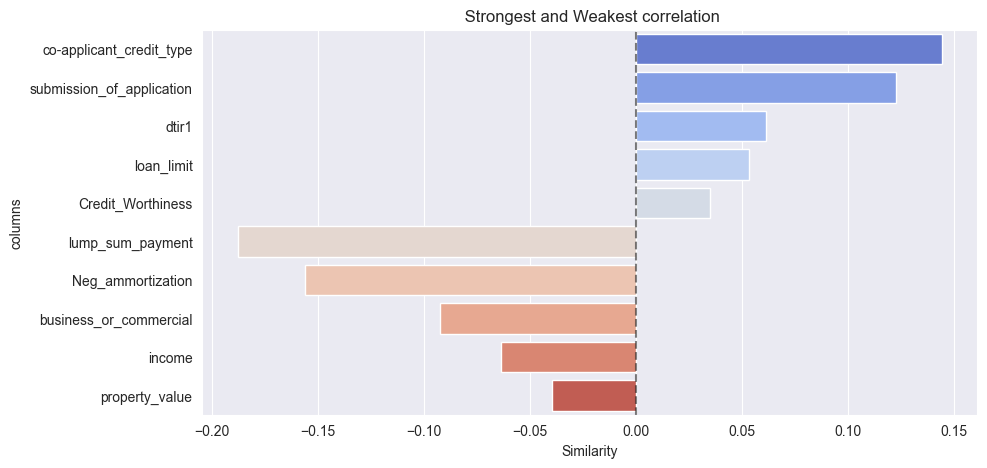

In [22]:
# 选择目标列（可以更改为你想分析的列）
target_col = "Status"  # 替换为你的目标列

# 只保留数值型列
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]


# 计算相关系数（皮尔逊）
corr_matrix = df_numeric.corr()
similarity_scores = corr_matrix[target_col].drop(target_col)  # 去掉自身

# 获取最相似和最不相似的列（前5和后5）
top_5 = similarity_scores.nlargest(5)
bottom_5 = similarity_scores.nsmallest(5)

# 合并结果
similarity_df = pd.concat([top_5, bottom_5])

# 可视化
plt.figure(figsize=(10, 5))
sns.barplot(x=similarity_df.values, y=similarity_df.index, palette="coolwarm")
plt.xlabel("Similarity")
plt.ylabel("columns")
plt.title(f" Strongest and Weakest correlation")
plt.axvline(x=0, color="black", linestyle="--", alpha=0.5)  # 添加0轴线
plt.show()

<Axes: xlabel='Status'>

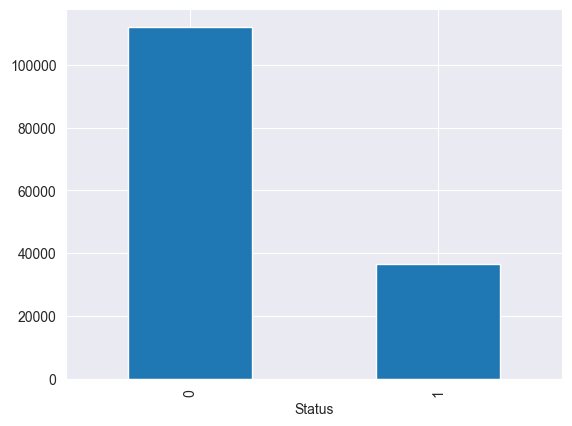

In [23]:
# Know the distribution of target variable
df['Status'].value_counts(normalize=True)
# visualize the distribution of target variable
df['Status'].value_counts().plot(kind='bar')

In [24]:
# define X and y
X = df.drop(columns=target_var)
y = df[target_var]
df.head()

,loan_limit,approv_in_adv,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,term,Neg_ammortization,interest_only,lump_sum_payment,...,credit_type_EXP,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,Region_North-East,Region_central,Region_south
0,0,0,0,0,1,116500,360.0,1,1,1,...,True,False,False,False,False,False,False,False,False,True
1,0,0,0,0,0,206500,360.0,1,1,0,...,False,False,False,True,False,False,False,False,False,False
2,0,1,0,0,1,406500,360.0,0,1,1,...,True,True,False,False,False,False,False,False,False,True
3,0,0,0,0,1,456500,360.0,1,1,1,...,True,False,True,False,False,False,False,False,False,False
4,0,1,0,0,1,696500,360.0,1,1,1,...,False,False,False,False,False,False,False,False,False,False


In [25]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((118936, 43), (29734, 43), (118936, 1), (29734, 1))

### MLP 模型训练与评估

In [26]:
trainer = MLPTrainer(X_train, y_train, X_test, y_test)
trainer.train()
trainer.evaluate()

Epoch 1/30 - Loss: 1635.0706
Epoch 2/30 - Loss: 1360.4283
Epoch 3/30 - Loss: 1318.9982
Epoch 4/30 - Loss: 1293.8174
Epoch 5/30 - Loss: 1275.3462
Epoch 6/30 - Loss: 1259.2953
Epoch 7/30 - Loss: 1250.3085
Epoch 8/30 - Loss: 1239.7748


KeyboardInterrupt: 

### LightGBM 模型训练与评估

D:\anaconda\envs\hku\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda\envs\hku\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29399, number of negative: 89537
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 118936, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247183 -> initscore=-1.113691
[LightGBM] [Info] Start training from score -1.113691

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     22494
           1       0.76      0.72      0.74      7240

    accuracy                           0.88     29734
   macro avg       0.84      0.82      0.83     29734
weighted avg       0.87      0.88      0.88     29734

🎯 AUC-RO

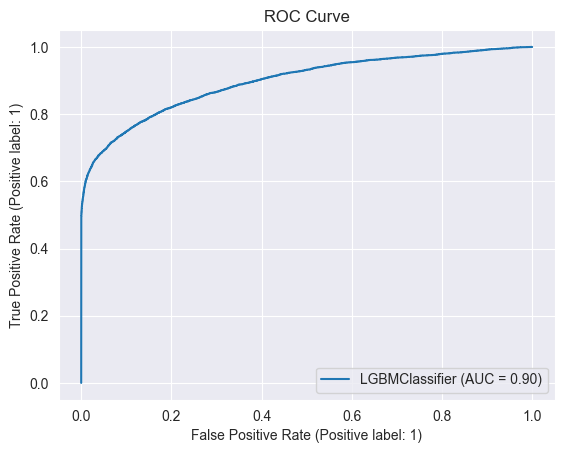

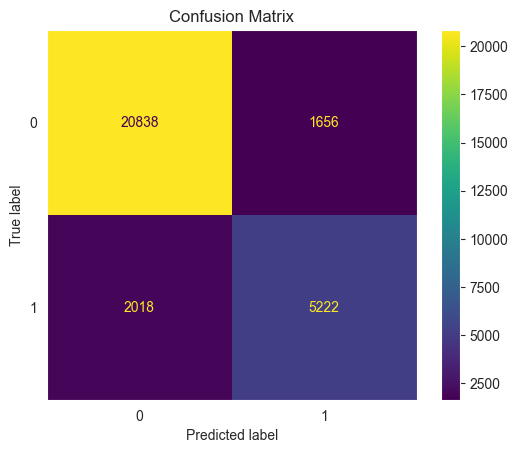


🔍 Top Feature Importances:
                      Feature  Importance
18                        LTV        1903
14                     income        1634
20                      dtir1        1308
15               Credit_Score        1138
5                 loan_amount        1097
10             property_value         948
6                        term         313
25            loan_type_type3         293
4      business_or_commercial         284
28            loan_purpose_p4         283
27            loan_purpose_p3         264
1               approv_in_adv         264
29          occupancy_type_pr         233
17  submission_of_application         213
2           Credit_Worthiness         193
7           Neg_ammortization         191
32           credit_type_EQUI         179
9            lump_sum_payment         177
37                  age_65-74         136
8               interest_only         127


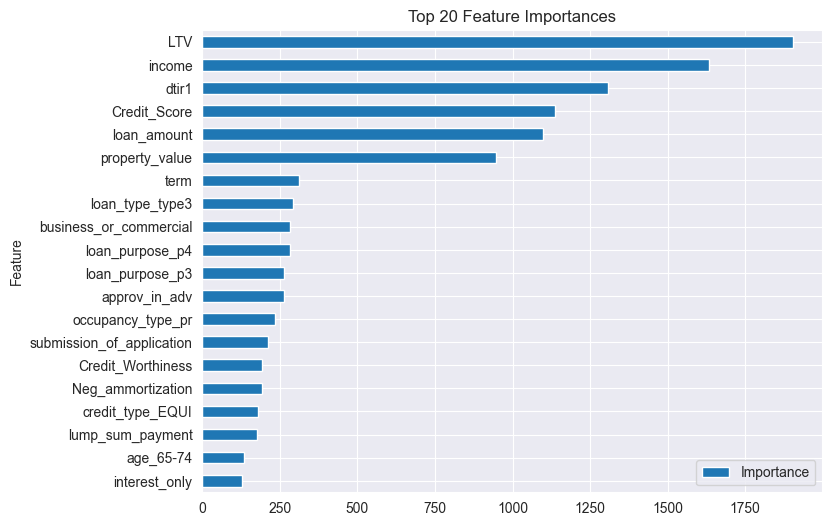

,Feature,Importance
18,LTV,1903
14,income,1634
20,dtir1,1308
15,Credit_Score,1138
5,loan_amount,1097
10,property_value,948
6,term,313
25,loan_type_type3,293
4,business_or_commercial,284
28,loan_purpose_p4,283


In [33]:
# from lightgbm import LGBMClassifier
# from sklearn.metrics import (
#     classification_report,
#     confusion_matrix,
#     roc_auc_score,
#     RocCurveDisplay,
#     ConfusionMatrixDisplay
# )
# import matplotlib.pyplot as plt
# 
# # ===== 模型训练 =====
# model = LGBMClassifier(
#     is_unbalance=True,     # 处理类别不平衡问题
#     random_state=42,
#     n_estimators=100,
#     learning_rate=0.05,
#     max_depth=-1,
#     num_leaves=31
# )
# 
# model.fit(X_train, y_train)
# 
# # ===== 预测 =====
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)[:, 1]  # 预测为违约的概率
# 
# # ===== 评估结果 =====
# 
# # 1. 分类报告（含 Precision, Recall, F1-score）
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# 
# # 2. 混淆矩阵
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))
# 
# # 3. AUC-ROC 分数
# auc = roc_auc_score(y_test, y_pred_proba)
# print(f"AUC-ROC Score: {auc:.4f}")
# 
# # ===== 可视化 =====
# 
# # 4. ROC 曲线
# RocCurveDisplay.from_estimator(model, X_test, y_test)
# plt.title("ROC Curve")
# plt.grid(True)
# plt.show()
# 
# # 5. 混淆矩阵图
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# plt.title("Confusion Matrix")
# plt.grid(False)
# plt.show()
# 初始化并训练
model = LightGBMLoanModel(categorical_features=[])
model.fit(X_train, y_train)

# 评估模型
model.evaluate(X_test, y_test)

# 查看特征重要性
model.feature_importance(X_train)

### XGBoost 模型训练与评估

D:\anaconda\envs\hku\lib\site-packages\xgboost\core.py:158: UserWarning: [03:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93     22494
           1       0.93      0.61      0.74      7240

    accuracy                           0.89     29734
   macro avg       0.91      0.80      0.84     29734
weighted avg       0.90      0.89      0.89     29734

🎯 AUC-ROC: 0.8941141302505714
🧩 Confusion Matrix:
[[22179   315]
 [ 2814  4426]]


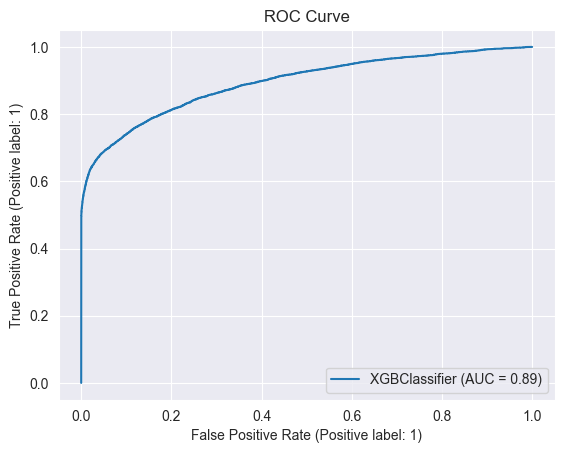

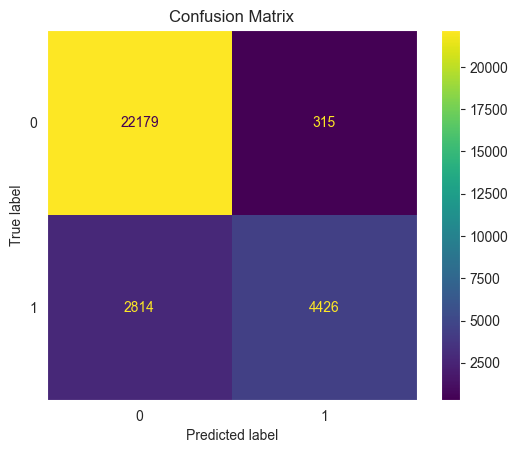


🔍 Top Feature Importances:
                      Feature  Importance
32           credit_type_EQUI    0.657919
9            lump_sum_payment    0.052227
7           Neg_ammortization    0.041059
2           Credit_Worthiness    0.028990
17  submission_of_application    0.026427
25            loan_type_type3    0.020934
20                      dtir1    0.018617
4      business_or_commercial    0.013362
18                        LTV    0.010077
14                     income    0.009940
28            loan_purpose_p4    0.009354
0                  loan_limit    0.008307
1               approv_in_adv    0.008296
21               Gender_Joint    0.007757
16   co-applicant_credit_type    0.007260
27            loan_purpose_p3    0.006954
8               interest_only    0.006845
5                 loan_amount    0.006409
29          occupancy_type_pr    0.006252
30          occupancy_type_sr    0.005820


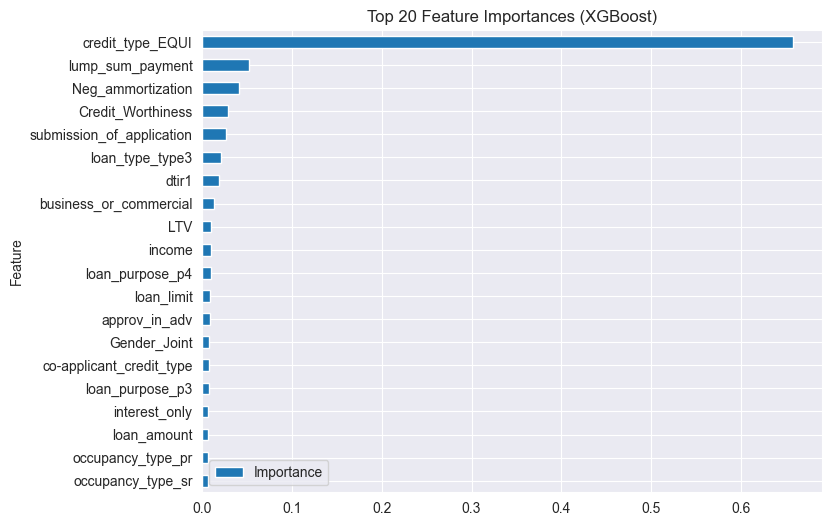

,Feature,Importance
32,credit_type_EQUI,0.657919
9,lump_sum_payment,0.052227
7,Neg_ammortization,0.041059
2,Credit_Worthiness,0.028990
17,submission_of_application,0.026427
25,loan_type_type3,0.020934
20,dtir1,0.018617
4,business_or_commercial,0.013362
18,LTV,0.010077
14,income,0.009940


In [28]:
# 假设你已有 X_train, X_test, y_train, y_test

# 初始化并训练
xgb_model = XGBoostLoanModel()
xgb_model.fit(X_train, y_train)

# 评估模型
xgb_model.evaluate(X_test, y_test)

# 查看特征重要性
xgb_model.feature_importance(X_train)


### 逻辑回归模型训练与评估

D:\anaconda\envs\hku\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     22494
           1       0.65      0.63      0.64      7240

    accuracy                           0.83     29734
   macro avg       0.77      0.76      0.76     29734
weighted avg       0.83      0.83      0.83     29734

🎯 AUC-ROC: 0.8371464127696175
🧩 Confusion Matrix:
[[20020  2474]
 [ 2648  4592]]


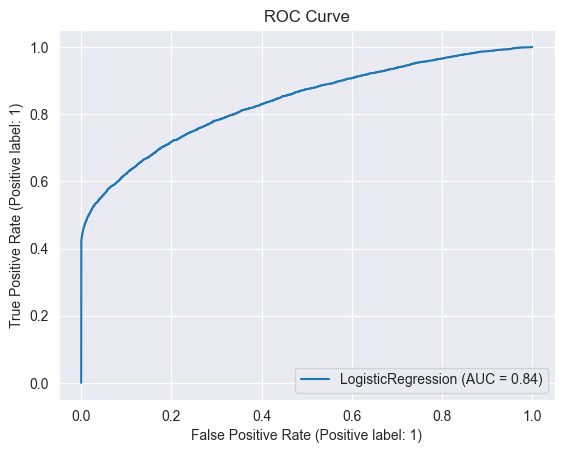

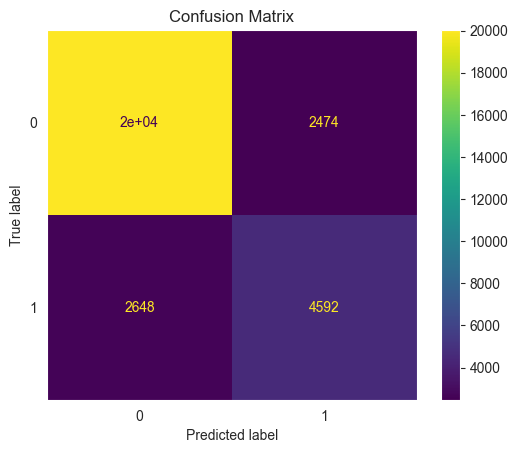


🔍 Top Feature Coefficients (by abs):
                      Feature  Importance
32           credit_type_EQUI    3.255404
18                        LTV    0.698425
9            lump_sum_payment   -0.386452
17  submission_of_application    0.353574
7           Neg_ammortization   -0.325638
14                     income   -0.242907
10             property_value    0.200304
29          occupancy_type_pr   -0.183946
0                  loan_limit    0.166492
16   co-applicant_credit_type   -0.143650
26            loan_purpose_p2    0.133313
28            loan_purpose_p4    0.119869
27            loan_purpose_p3    0.119691
36                  age_55-64    0.102683
20                      dtir1    0.098722
37                  age_65-74    0.089139
4      business_or_commercial   -0.086582
24            loan_type_type2    0.086582
42               Region_south    0.081411
25            loan_type_type3   -0.080873


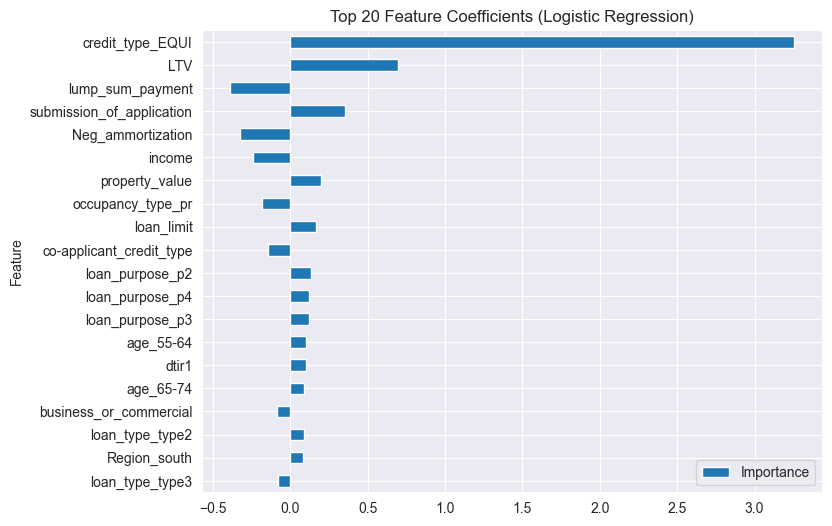

,Feature,Importance
32,credit_type_EQUI,3.255404
18,LTV,0.698425
9,lump_sum_payment,-0.386452
17,submission_of_application,0.353574
7,Neg_ammortization,-0.325638
14,income,-0.242907
10,property_value,0.200304
29,occupancy_type_pr,-0.183946
0,loan_limit,0.166492
16,co-applicant_credit_type,-0.143650


In [32]:
# 初始化模型（默认标准化）
lr_model = LogisticRegressionLoanModel()

# 模型训练
lr_model.fit(X_train, y_train)

# 模型评估
lr_model.evaluate(X_test, y_test)

# 查看特征重要性（系数）
lr_model.feature_importance(X_train)


### CatBoost 模型训练与评估


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     22494
           1       0.76      0.70      0.73      7240

    accuracy                           0.87     29734
   macro avg       0.83      0.82      0.83     29734
weighted avg       0.87      0.87      0.87     29734

🎯 AUC-ROC: 0.8915785799479002
🧩 Confusion Matrix:
[[20904  1590]
 [ 2137  5103]]


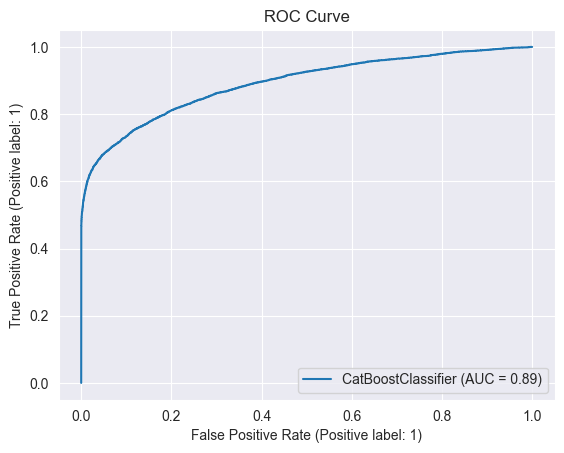

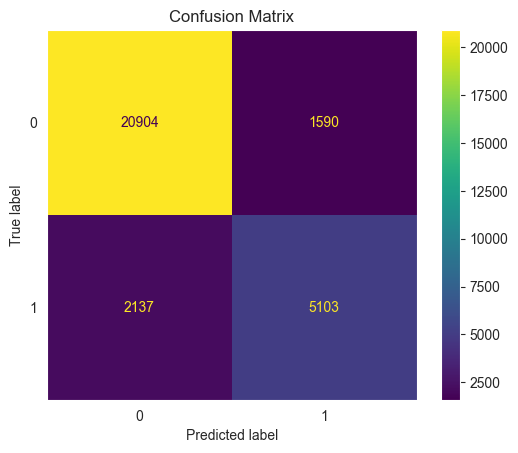

In [36]:
cat_model = CatBoostLoanModel(categorical_features=[])  # 或不写这个参数
cat_model.fit(X_train, y_train)
cat_model.evaluate(X_test, y_test)
